# Test the prior. How important is it?

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

import glob
import aviary as av
from tqdm import trange
import starspot as ss

plotpar = {'axes.labelsize': 20,
           'font.size': 22,
           'legend.fontsize': 15,
           'xtick.labelsize': 15,
           'ytick.labelsize': 15,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Load the results.

In [113]:
def load_results(files):
    results = pd.read_csv(files[0])
    for i in trange(1, len(files)):
        results = pd.concat([results, pd.read_csv(files[i])])
    return results

faint_files = glob.glob("../velocities/faint_prior/*csv")
bright_files = glob.glob("../velocities/bright_prior/*csv")
files = glob.glob("../velocities/all_stars_with_rvs/*csv")

faint = load_results(faint_files)
bright = load_results(bright_files)

100%|██████████| 2161/2161 [00:07<00:00, 307.77it/s]


In [4]:
all_ = load_results(files)

100%|██████████| 4999/4999 [00:14<00:00, 354.20it/s]


Load the data file.

In [5]:
# Load data.
vels = pd.read_csv("../../aviary/mc_san_gaia_lam.csv")
lnD = np.log(1./vels.parallax.values)

finite = np.isfinite(vels.vx.values)
finite &= np.isfinite(vels.vy.values)
finite &= np.isfinite(vels.vz.values)

# Get rid of outliers
nsigma = 3
mx = ss.sigma_clip(vels.vx.values[finite], nsigma=nsigma)
my = ss.sigma_clip(vels.vy.values[finite], nsigma=nsigma)
mz = ss.sigma_clip(vels.vz.values[finite], nsigma=nsigma)
md = ss.sigma_clip(lnD[finite], nsigma=nsigma)
m = mx & my & mz & md

/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Merge the results file with the data file.

In [114]:
df_faint = pd.merge(vels, faint, on="kepid", how="right")
df_bright = pd.merge(vels, bright, on="kepid", how="right")
df = pd.merge(vels, all_, on="kepid", how="right")

In [81]:
print(np.shape(vels), np.shape(df_faint), np.shape(df_bright), np.shape(df))

(35328, 181) (3857, 198) (1070, 198) (5000, 198)


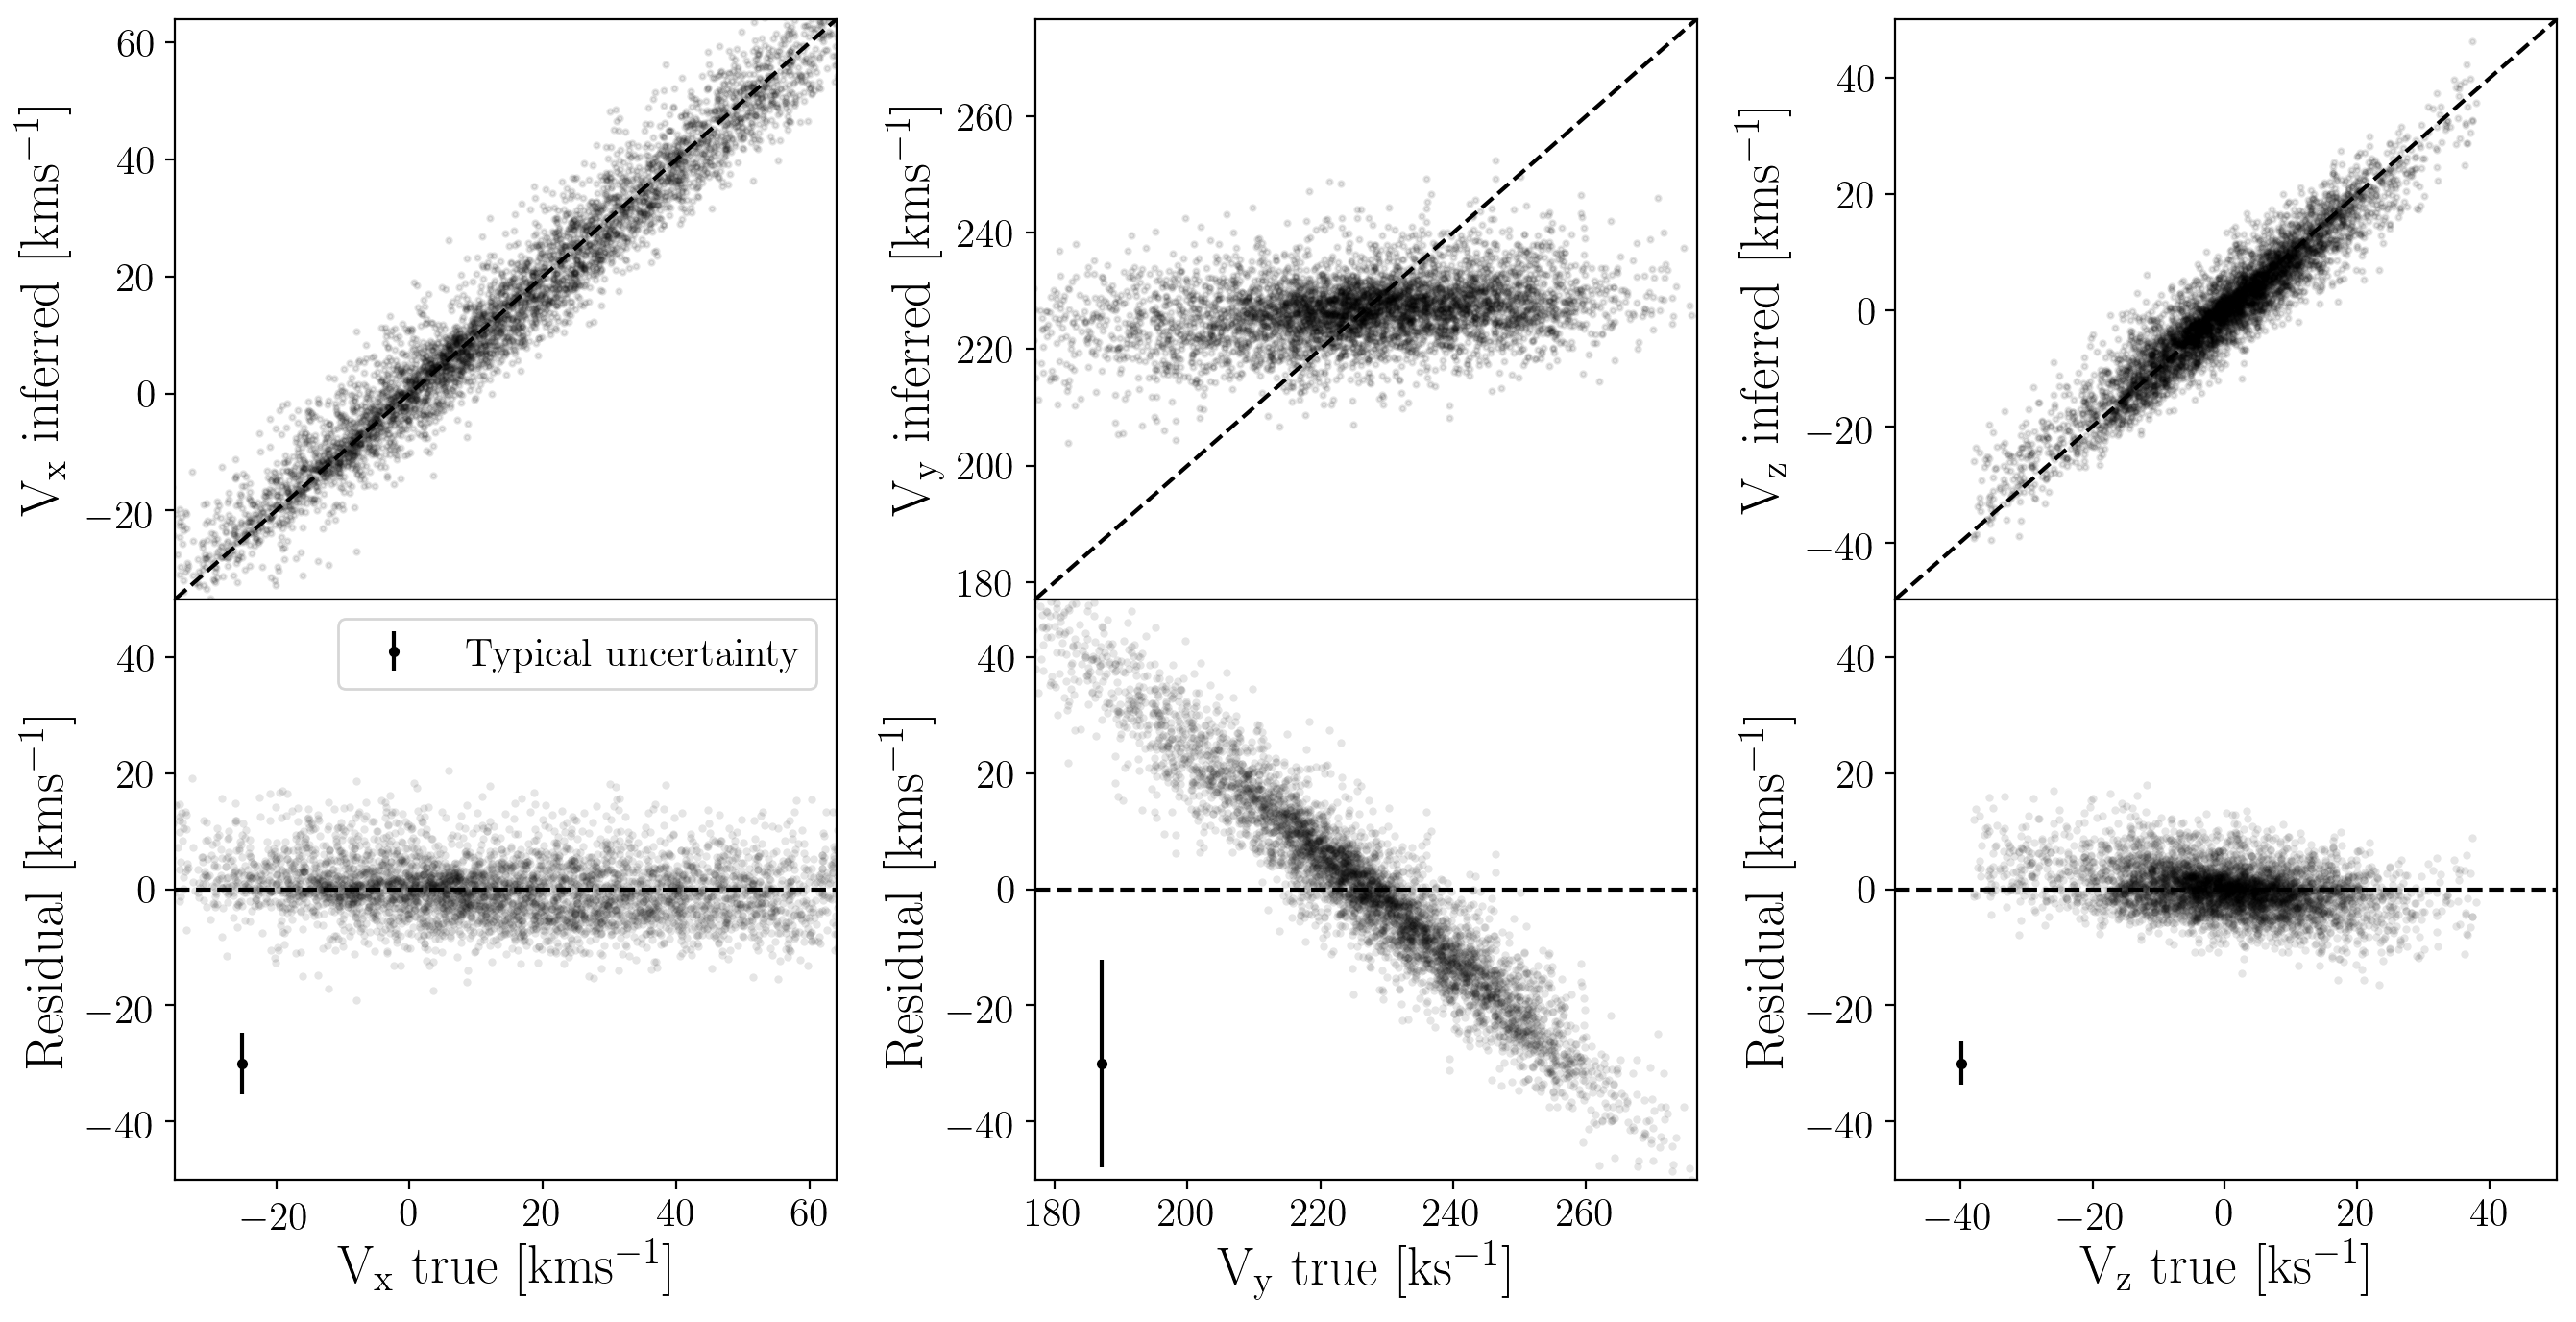

In [112]:
def resid_plot(vx, vy, vz, vx_inferred, vy_inferred, vz_inferred, vx_inferred_err, vy_inferred_err, vz_inferred_err,
               ms=4, alpha=.1, box_size=50):

    fig = plt.figure(figsize=(16, 8), dpi=200)
    gs = gridspec.GridSpec(2, 3, hspace=.0, wspace=.3, height_ratios=[1, 1])

    # ax0 = fig.add_subplot(231)
    ax0 = plt.subplot(gs[0, 0])
    xlims = (np.median(vx) - box_size, np.median(vx_inferred) + box_size)
    ax0.plot(vx, vx_inferred, "k.", ms=ms, alpha=alpha, rasterized=True, zorder=0)
    # xs = np.linspace(-100, 150, 100)
    xs = np.linspace(xlims[0], xlims[1], 100)
    plt.plot(xs, xs, "k", ls="--", zorder=1)
    # ax0.set_ylim(-100, 150)
    ax0.set_ylim(xlims)
    ax0.set_xlim(xlims)
    ax0.set_ylabel("$\mathrm{V_x~inferred~[kms^{-1}]}$")
    ax0.set_xticklabels([])

    # ax1 = fig.add_subplot(232)
    ax1 = plt.subplot(gs[0, 1])
    ylims = (np.median(vy) - box_size, np.median(vy_inferred) + box_size)
    ax1.plot(vy, vy_inferred, "k.", ms=ms, alpha=alpha, rasterized=True, zorder=0)
    xs = np.linspace(ylims[0], ylims[1], 100)
    plt.plot(xs, xs, "k", ls="--", zorder=1)
    # ax1.set_ylim(180, 270)
    ax1.set_xlim(ylims)
    ax1.set_ylim(ylims)
    ax1.set_ylabel("$\mathrm{V_y~inferred~[kms^{-1}]}$")
    ax1.set_xticklabels([])

    # ax2 = fig.add_subplot(233)
    ax2 = plt.subplot(gs[0, 2])
    zlims = (np.median(vz) - box_size, np.median(vz_inferred) + box_size)
    ax2.plot(vz, vz_inferred, "k.", ms=ms, alpha=alpha, rasterized=True, zorder=0)
    xs = np.linspace(zlims[0], zlims[1], 100)
    plt.plot(xs, xs, "k", ls="--", zorder=1)
    # ax2.set_ylim(-50, 50)
    ax2.set_xlim(zlims)
    ax2.set_ylim(zlims)
    ax2.set_ylabel("$\mathrm{V_z~inferred~[kms^{-1}]}$");
    ax2.set_xticklabels([])

    # ax3 = fig.add_subplot(234, sharex=ax0)
    ax3 = plt.subplot(gs[1, 0])
    ax3.plot(vx, vx_inferred - vx, "k.", ms=ms+2, mec="none", alpha=alpha, rasterized=True, zorder=0)
    ax3.errorbar(np.median(vx - 40), -30, yerr=np.median(vx_inferred_err), fmt="k.", label="$\mathrm{Typical~uncertainty}$")
    ax3.axhline(0, color="k", ls="--", zorder=1)
    ax3.set_ylim(-box_size, box_size)
    ax3.set_xlim(xlims)
    ax3.set_xlabel("$\mathrm{V_x~true~[kms^{-1}]}$")
    # ax3.set_ylabel("$\mathrm{V_{x, true} - V_{x, inferred}~[kms^{-1}]}$")
    ax3.set_ylabel("$\mathrm{Residual~[kms^{-1}]}$")
    ax3.legend()

    # ax4 = fig.add_subplot(235, sharex=ax1)
    ax4 = plt.subplot(gs[1, 1])
    ax4.plot(vy, vy_inferred - vy, "k.", ms=ms+2, mec="none", alpha=alpha, rasterized=True, zorder=0)
    ax4.errorbar(np.median(vy - 40), -30, yerr=np.median(vy_inferred_err), fmt="k.")
    ax4.axhline(0, color="k", ls="--", zorder=1)
    ax4.set_ylim(-box_size, box_size)
    ax4.set_xlim(ylims)
    ax4.set_xlabel("$\mathrm{V_y~true~[ks^{-1}]}$")
    # ax4.set_ylabel("$\mathrm{V_{y, true} - V_{y, inferred}~[kms^{-1}]}$")
    ax4.set_ylabel("$\mathrm{Residual~[kms^{-1}]}$")

    # ax5 = fig.add_subplot(236, sharex=ax2)
    ax5 = plt.subplot(gs[1, 2])
    ax5.plot(vz, vz_inferred - vz, "k.", ms=ms+2, mec="none", alpha=alpha, rasterized=True, zorder=0)
    ax5.errorbar(np.median(vz - 40), -30, yerr=np.median(vz_inferred_err), fmt="k.")
    ax5.axhline(0, color="k", ls="--", zorder=1)
    ax5.set_ylim(-box_size, box_size)
    ax5.set_xlim(zlims)
    ax5.set_xlabel("$\mathrm{V_z~true~[ks^{-1}]}$")
    # ax5.set_ylabel("$\mathrm{V_{z, true} - V_{z, inferred}~[kms^{-1}]}$");
    ax5.set_ylabel("$\mathrm{Residual~[kms^{-1}]}$")
        
    return fig

fig = resid_plot(df.vx, df.vy, df.vz, df.vx_inferred, df.vy_inferred, df.vz_inferred,
                 df.vx_inferred_err, df.vy_inferred_err, df.vz_inferred_err)

# plt.tight_layout()
plt.savefig("residuals")
plt.savefig("../../paper/residuals.pdf")

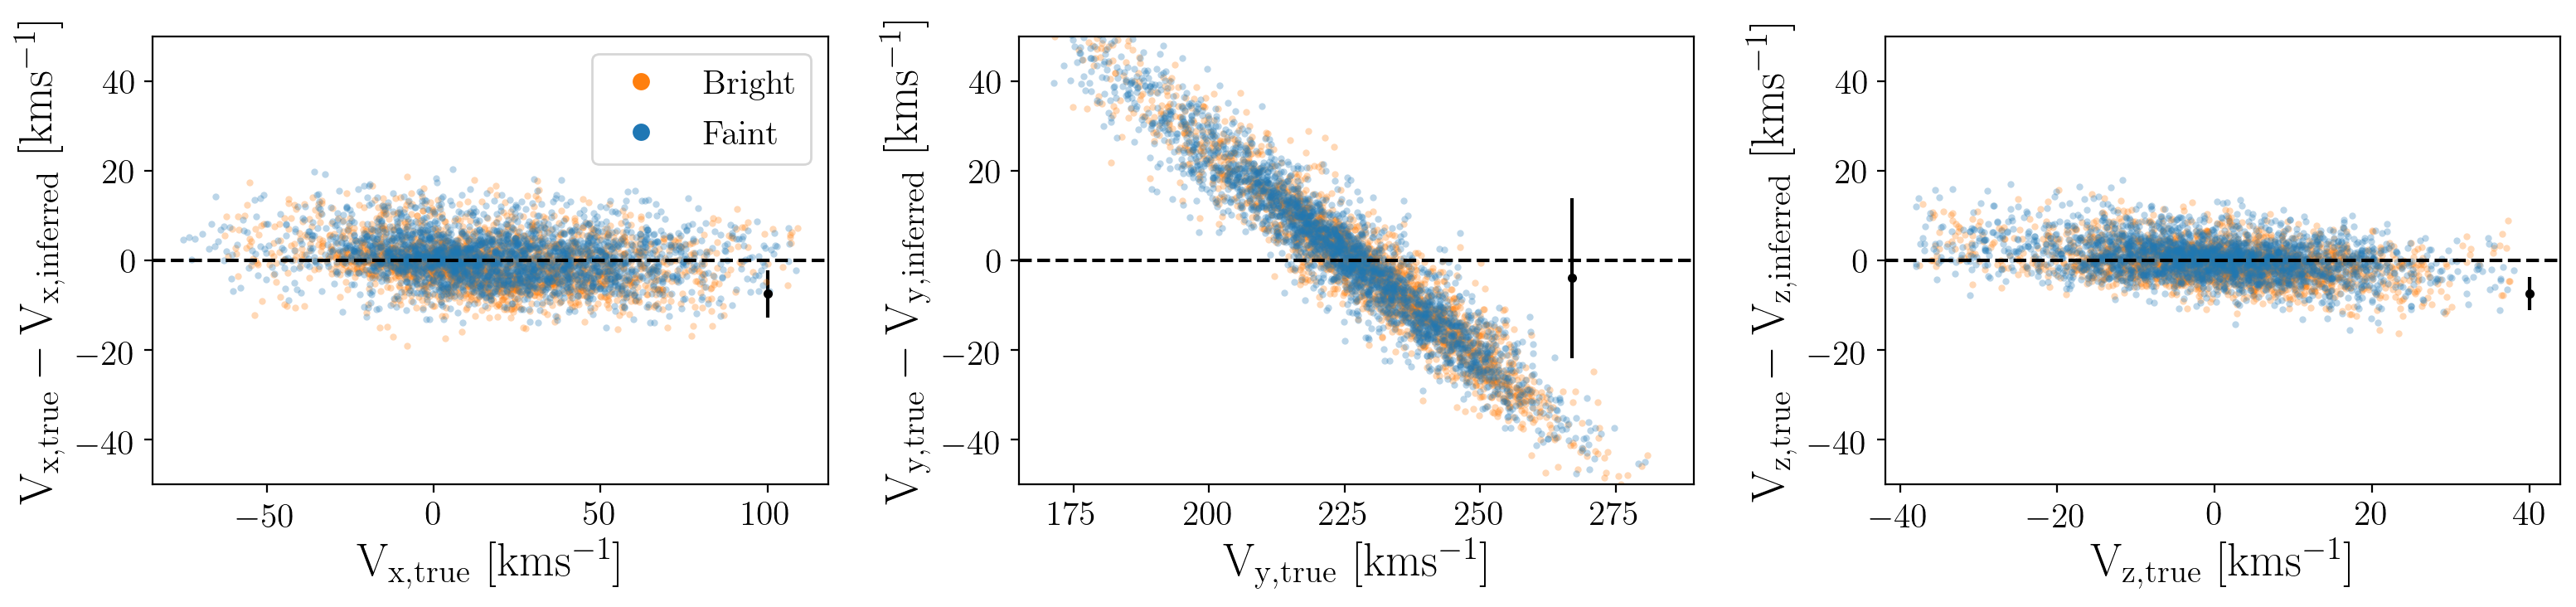

In [11]:
alpha, ms = .3, 6

b = df.phot_g_mean_mag.values < np.median(df.phot_g_mean_mag.values)
f = df.phot_g_mean_mag.values > np.median(df.phot_g_mean_mag.values)

fig = plt.figure(figsize=(16, 4), dpi=200)
ax0 = fig.add_subplot(131)
ax0.plot(df.vx.values[b], df.vx_inferred.values[b] - df.vx.values[b], "C1.", ms=ms, mec="none", alpha=alpha, rasterized=True, label="$\mathrm{Bright}$")
ax0.plot(df.vx.values[f], df.vx_inferred.values[f] - df.vx.values[f], "C0.", ms=ms, mec="none", alpha=alpha, rasterized=True, label="$\mathrm{Faint}$")
ax0.errorbar(100, -7.5, yerr=np.median(df.vx_inferred_err), fmt="k.")
ax0.axhline(0, color="k", ls="--")
ax0.set_xlabel("$\mathrm{V_{x, true}~[kms^{-1}]}$")
ax0.set_ylabel("$\mathrm{V_{x, true} - V_{x, inferred}~[kms^{-1}]}$")
ax0.set_ylim(-50, 50)
leg = ax0.legend()
leg.legendHandles[0]._legmarker.set_markersize(15)
leg.legendHandles[1]._legmarker.set_markersize(15)
leg.legendHandles[0]._legmarker.set_alpha(1)
leg.legendHandles[1]._legmarker.set_alpha(1)

ax1 = fig.add_subplot(132)
ax1.plot(df.vy.values[b], df.vy_inferred.values[b] - df.vy.values[b], "C1.", ms=ms, mec="none", alpha=alpha, rasterized=True)
ax1.plot(df.vy.values[f], df.vy_inferred.values[f] - df.vy.values[f], "C0.", ms=ms, mec="none", alpha=alpha, rasterized=True)
ax1.errorbar(267, -4, yerr=np.median(df.vy_inferred_err), fmt="k.")
ax1.axhline(0, color="k", ls="--")
ax1.set_xlabel("$\mathrm{V_{y, true}~[kms^{-1}]}$")
ax1.set_ylabel("$\mathrm{V_{y, true} - V_{y, inferred}~[kms^{-1}]}$")
ax1.set_ylim(-50, 50)

ax2 = fig.add_subplot(133)
ax2.plot(df.vz.values[b], df.vz_inferred.values[b] - df.vz.values[b], "C1.", ms=ms, mec="none", alpha=alpha, rasterized=True)
ax2.plot(df.vz.values[f], df.vz_inferred.values[f] - df.vz.values[f], "C0.", ms=ms, mec="none", alpha=alpha, rasterized=True)
ax2.errorbar(40, -7.5, yerr=np.median(df.vz_inferred_err), fmt="k.")
ax2.axhline(0, color="k", ls="--")
ax2.set_xlabel("$\mathrm{V_{z, true}~[kms^{-1}]}$")
ax2.set_ylabel("$\mathrm{V_{z, true} - V_{z, inferred}~[kms^{-1}]}$");
ax2.set_ylim(-50, 50)

plt.tight_layout()
plt.savefig("residual_brightness")

Look at the differences in the residuals between the bright and faint stars.

In [12]:
import scipy.stats as sps

def kde(v, xlim):
    kernel = sps.gaussian_kde(v)
    xs = np.linspace(xlim[0], xlim[1], 100)
    return xs, kernel(xs)

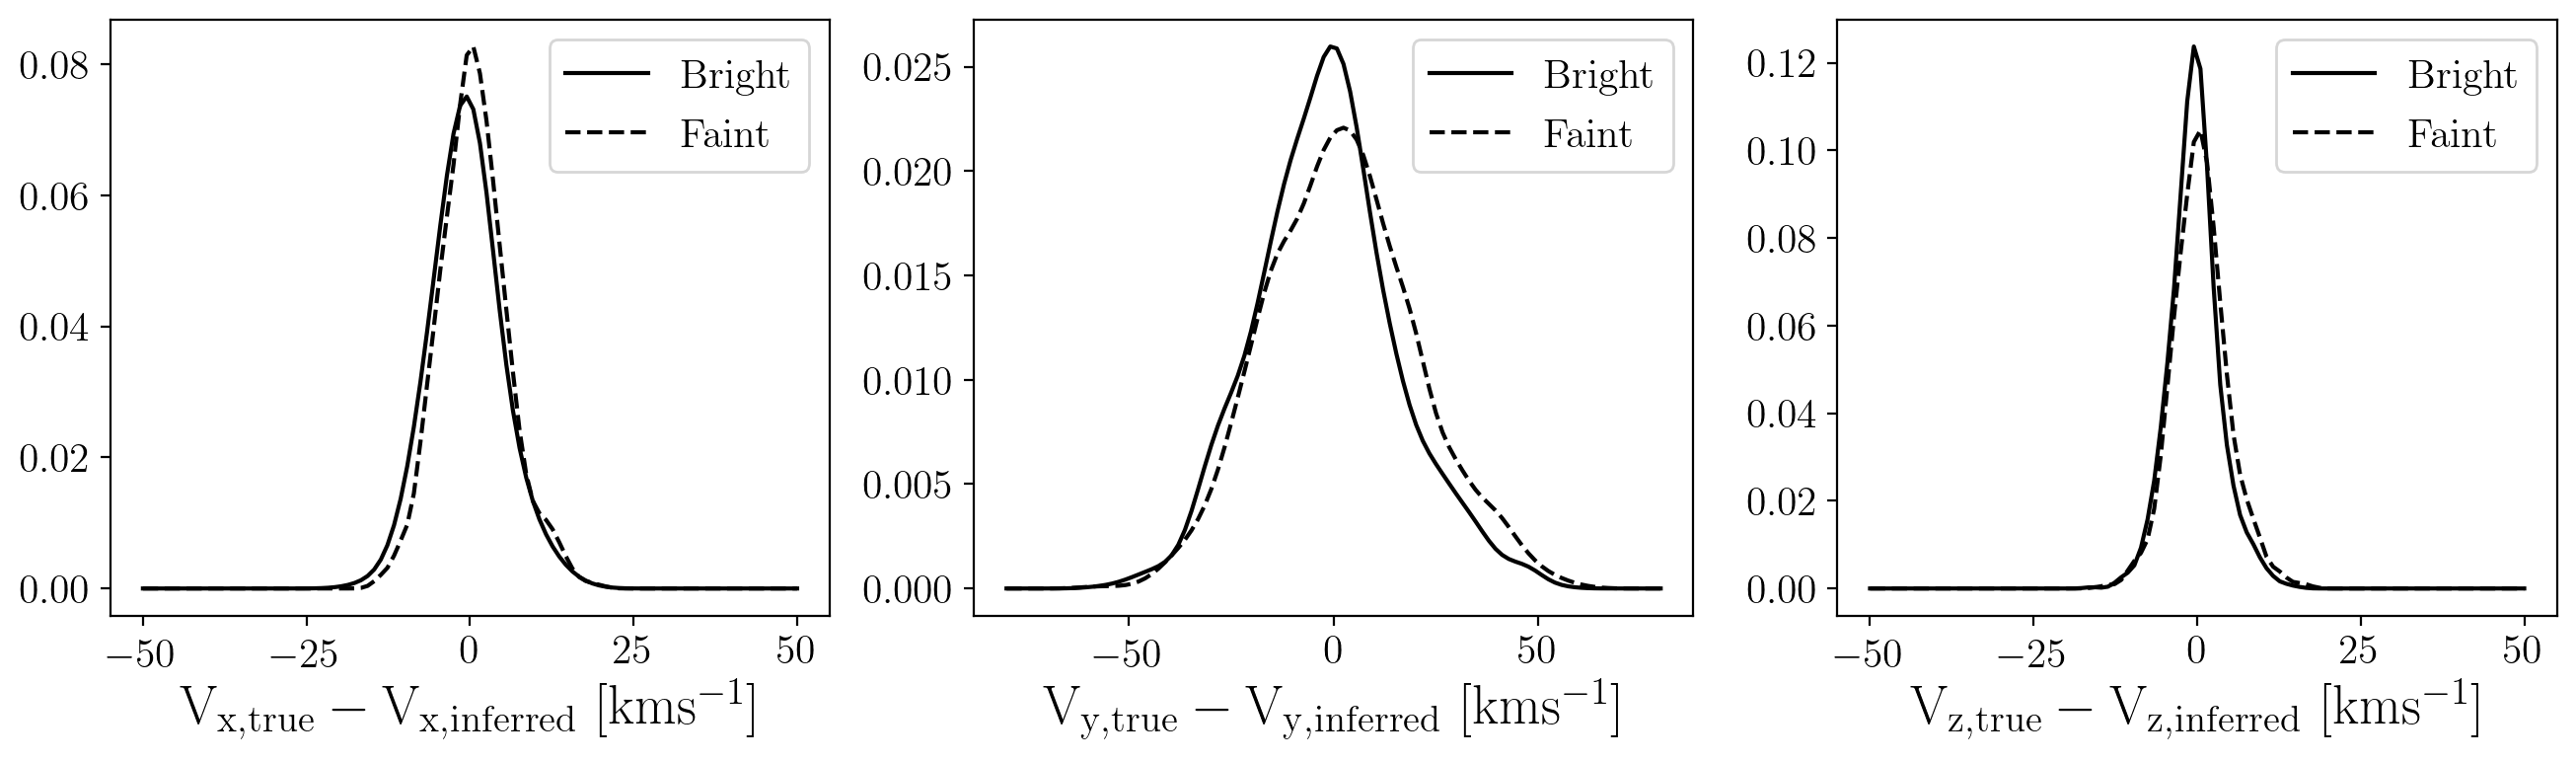

In [13]:
fig = plt.figure(figsize=(16, 4), dpi=200)

def kde_plot(xb, xf, yb, yf, zb, zf):
    ax0 = fig.add_subplot(131)
    xsb, kb = kde(xb, [-50, 50])
    xsf, kf = kde(xf, [-50, 50])
    ax0.plot(xsb, kb, color="k", ls="-", label="$\mathrm{Bright}$");
    ax0.plot(xsf, kf, color="k", ls="--", label="$\mathrm{Faint}$");
    # ax0.hist(df.vx_inferred.values[b] - df.vx.values[b], 50, density=True, alpha=.5, color="C1", label="$\mathrm{Bright}$")
    # ax0.hist(df.vx_inferred.values[f] - df.vx.values[f], 50, density=True, alpha=.5, color="C0", label="$\mathrm{Faint}$")
    ax0.legend()
    ax0.set_xlabel("$\mathrm{V_{x, true} - V_{x, inferred}~[kms^{-1}]}$")

    ax1 = fig.add_subplot(132)
    xsb, kb = kde(yb, [-80, 80])
    xsf, kf = kde(yf, [-80, 80])
    ax1.plot(xsb, kb, color="k", ls="-", label="$\mathrm{Bright}$");
    ax1.plot(xsf, kf, color="k", ls="--", label="$\mathrm{Faint}$");
    # ax1.hist(df.vy_inferred.values[b] - df.vy.values[b], 50, density=True, alpha=.5, color="C1", label="$\mathrm{Bright}$")
    # ax1.hist(df.vy_inferred.values[f] - df.vy.values[f], 50, density=True, alpha=.5, color="C0", label="$\mathrm{Faint}$")
    ax1.legend()
    ax1.set_xlabel("$\mathrm{V_{y, true} - V_{y, inferred}~[kms^{-1}]}$")

    ax2 = fig.add_subplot(133)
    xsb, kb = kde(zb, [-50, 50])
    xsf, kf = kde(zf, [-50, 50])
    ax2.plot(xsb, kb, color="k", ls="-", label="$\mathrm{Bright}$");
    ax2.plot(xsf, kf, color="k", ls="--", label="$\mathrm{Faint}$");
    # ax2.hist(df.vz_inferred.values[b] - df.vz.values[b], 50, density=True, alpha=.5, color="C1", label="$\mathrm{Bright}$")
    # ax2.hist(df.vz_inferred.values[f] - df.vz.values[f], 50, density=True, alpha=.5, color="C0", label="$\mathrm{Faint}$")
    ax2.legend()
    ax2.set_xlabel("$\mathrm{V_{z, true} - V_{z, inferred}~[kms^{-1}]}$")


xb, xf = df.vx_inferred.values[b] - df.vx.values[b], df.vx_inferred.values[f] - df.vx.values[f]
yb, yf = df.vy_inferred.values[b] - df.vy.values[b], df.vy_inferred.values[f] - df.vy.values[f]
zb, zf = df.vz_inferred.values[b] - df.vz.values[b], df.vz_inferred.values[f] - df.vz.values[f]
kde_plot(xb, xf, yb, yf, zb, zf)

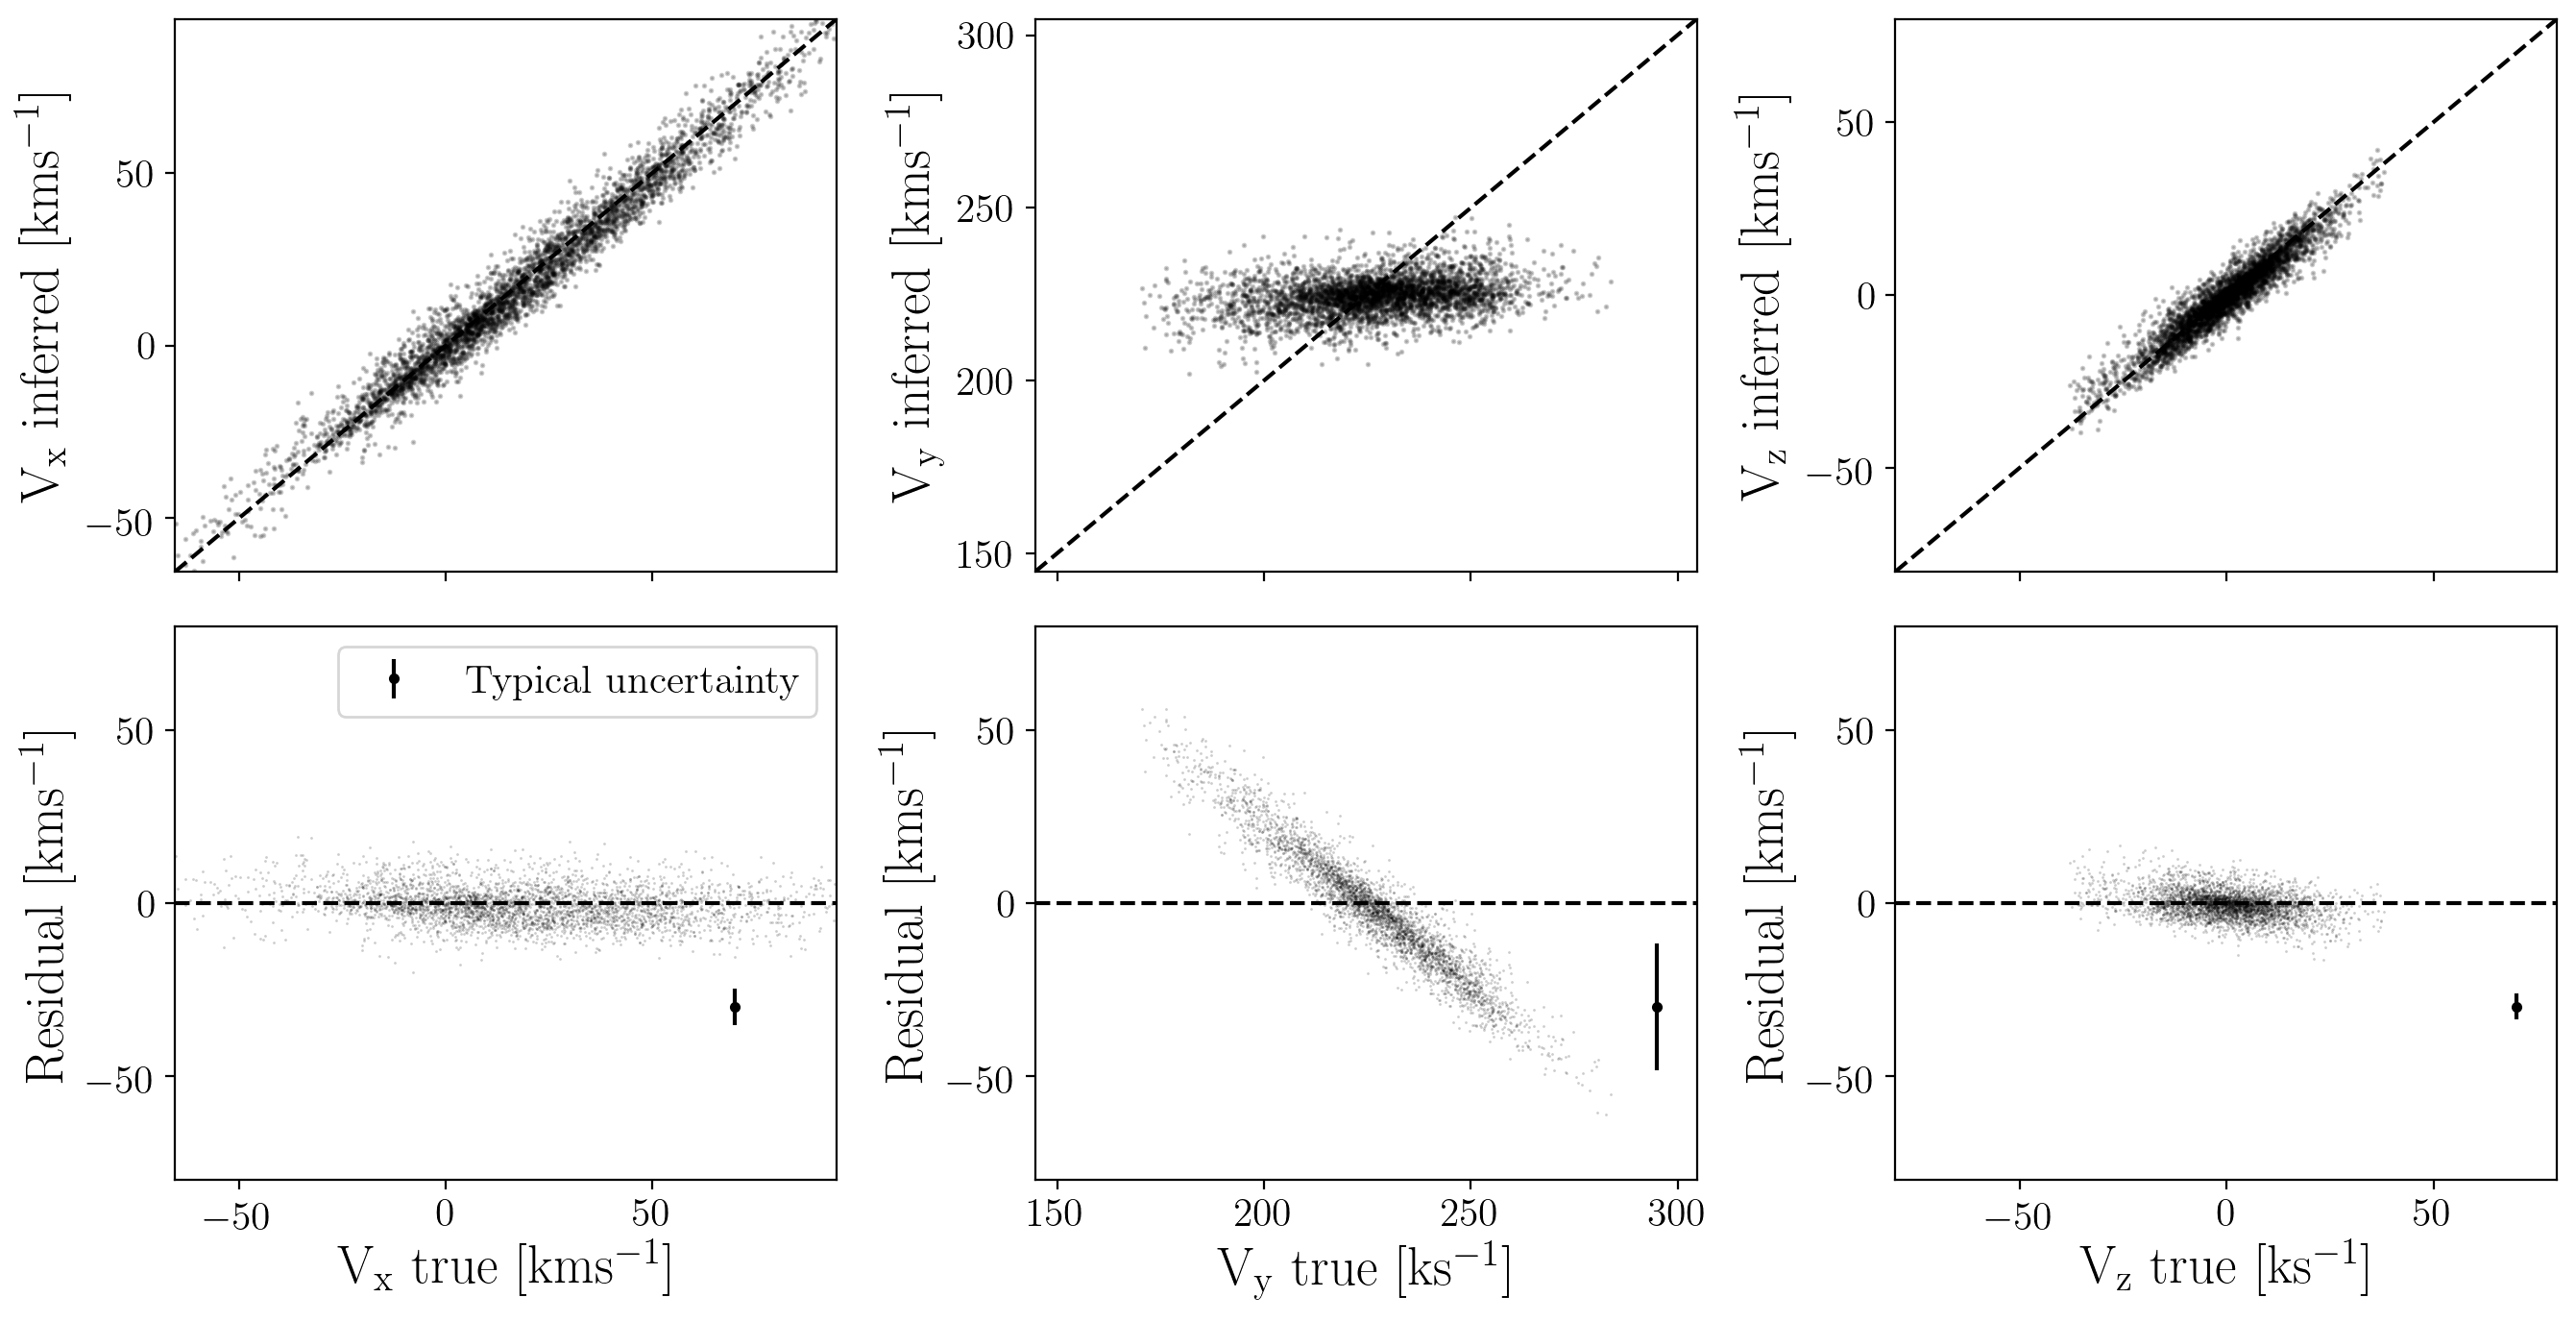

In [90]:
fig = resid_plot(df_faint.vx, df_faint.vy, df_faint.vz, df_faint.vx_inferred, df_faint.vy_inferred, df_faint.vz_inferred,
                 df_faint.vx_inferred_err, df_faint.vy_inferred_err, df_faint.vz_inferred_err, alpha=.2, ms=2)

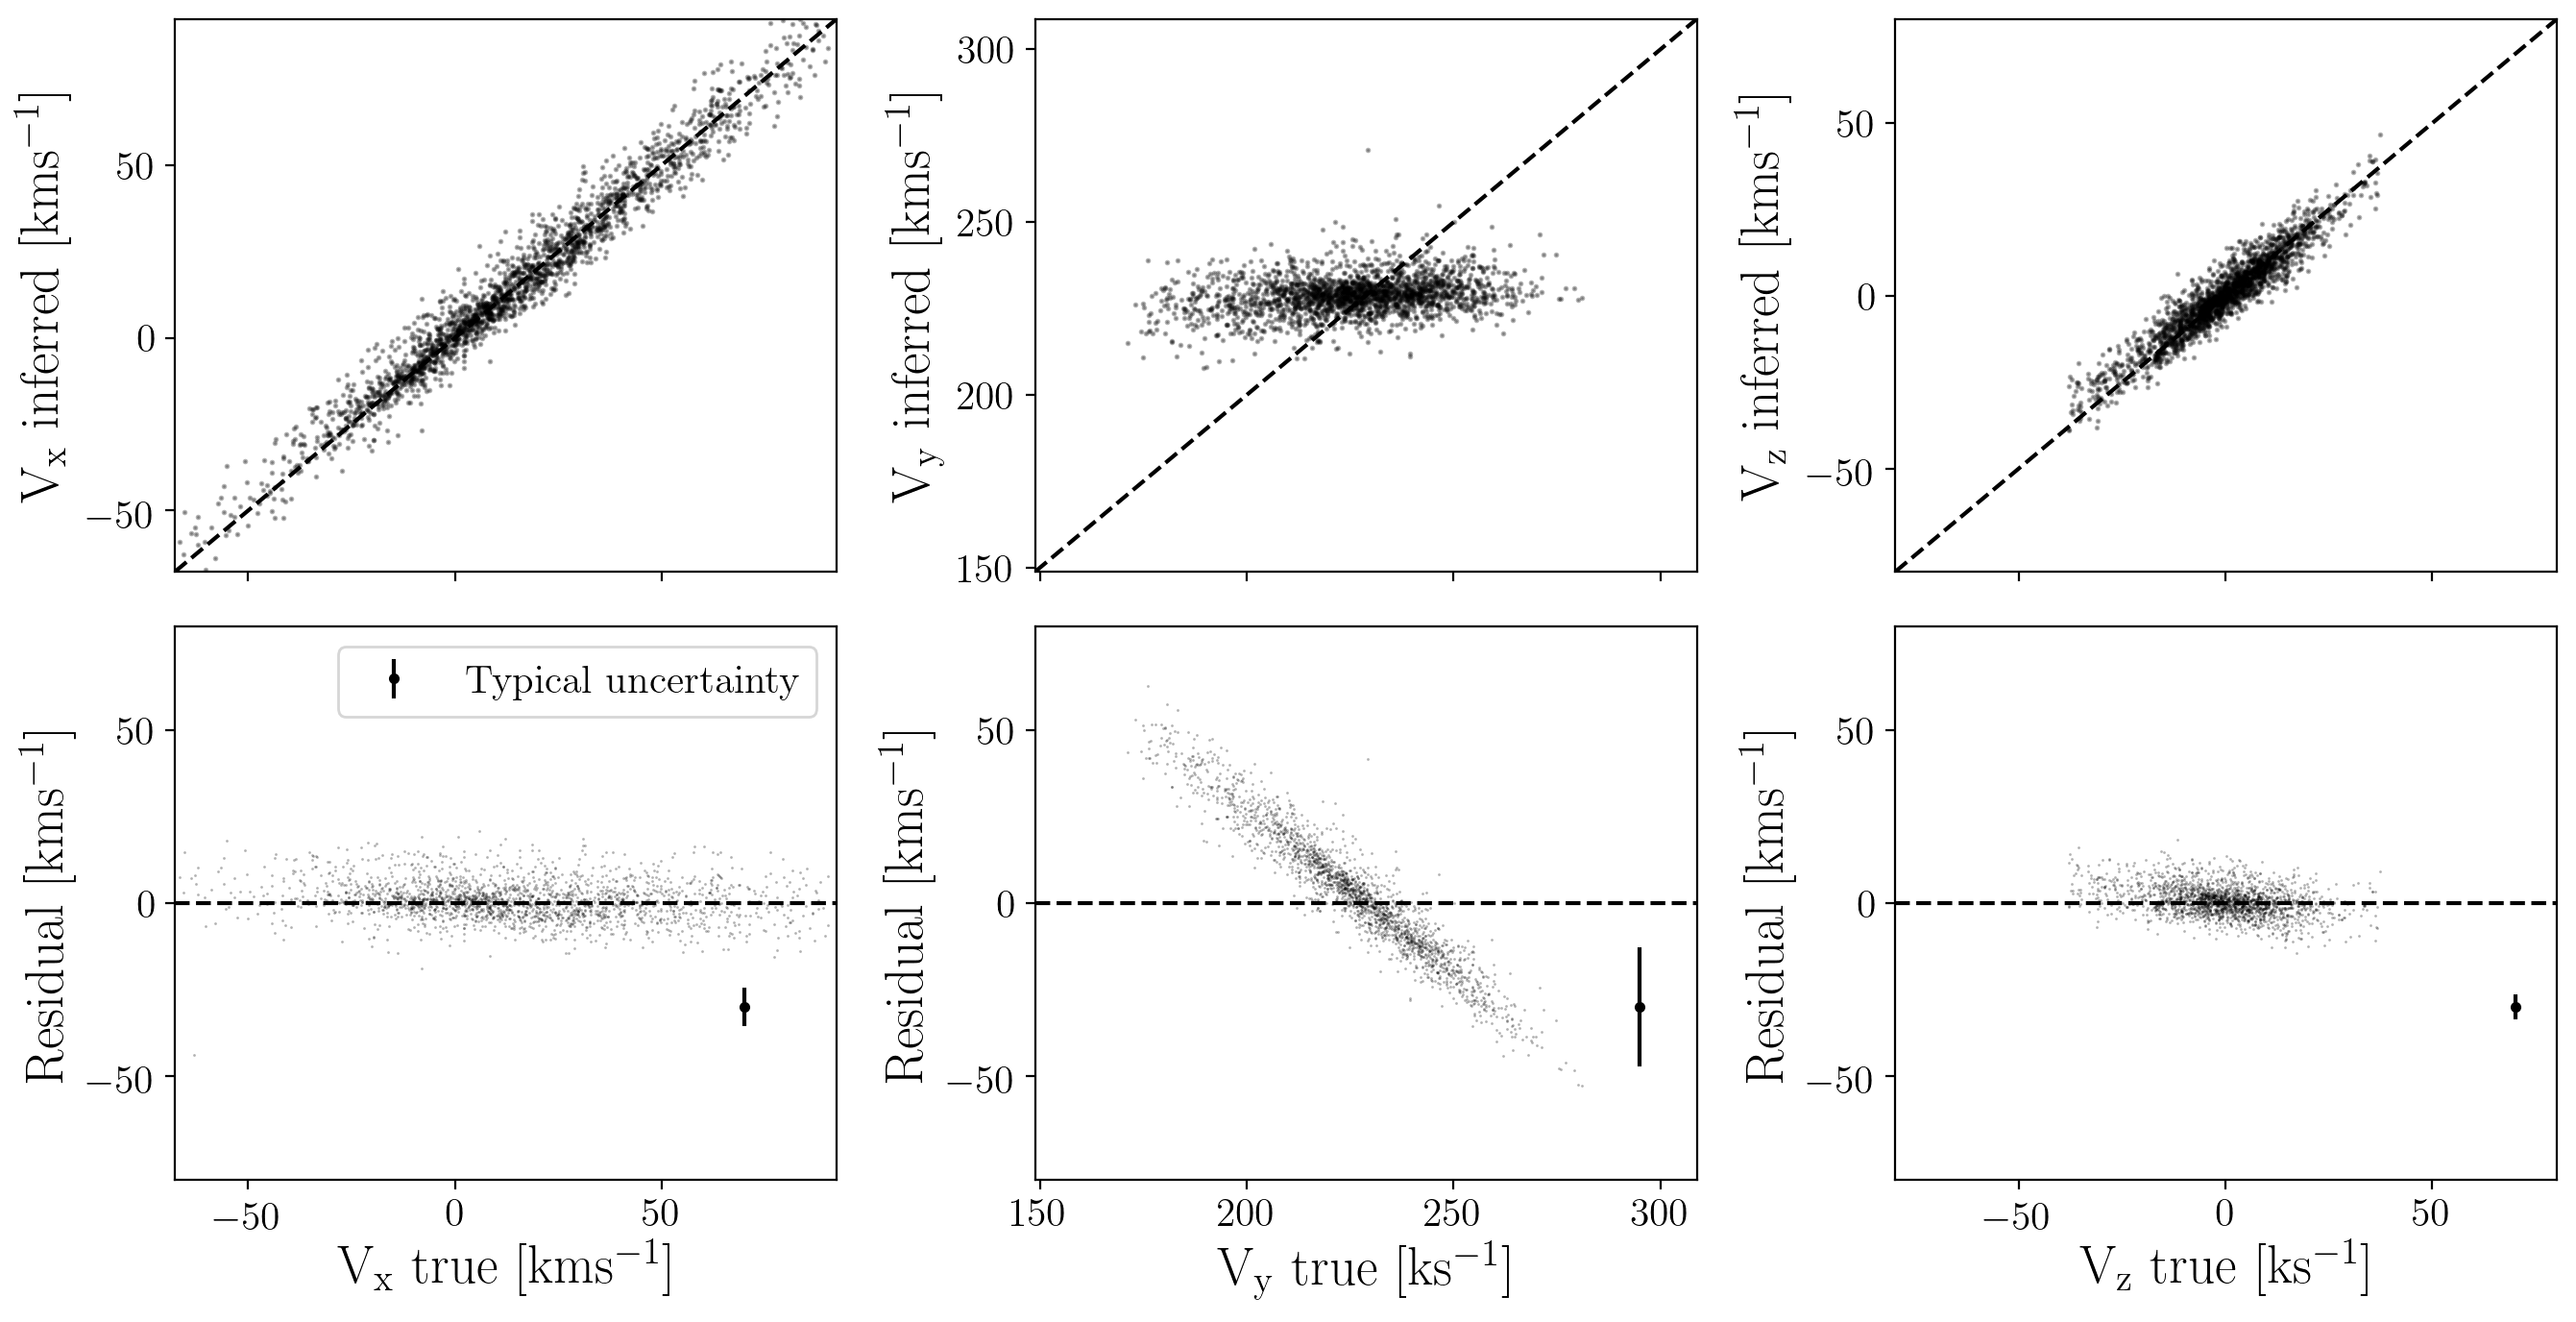

In [92]:
fig = resid_plot(df_bright.vx, df_bright.vy, df_bright.vz, df_bright.vx_inferred, df_bright.vy_inferred, df_bright.vz_inferred,
                 df_bright.vx_inferred_err, df_bright.vy_inferred_err, df_bright.vz_inferred_err, alpha=.3, ms=2)

Compare distributions of faint, bright and all.

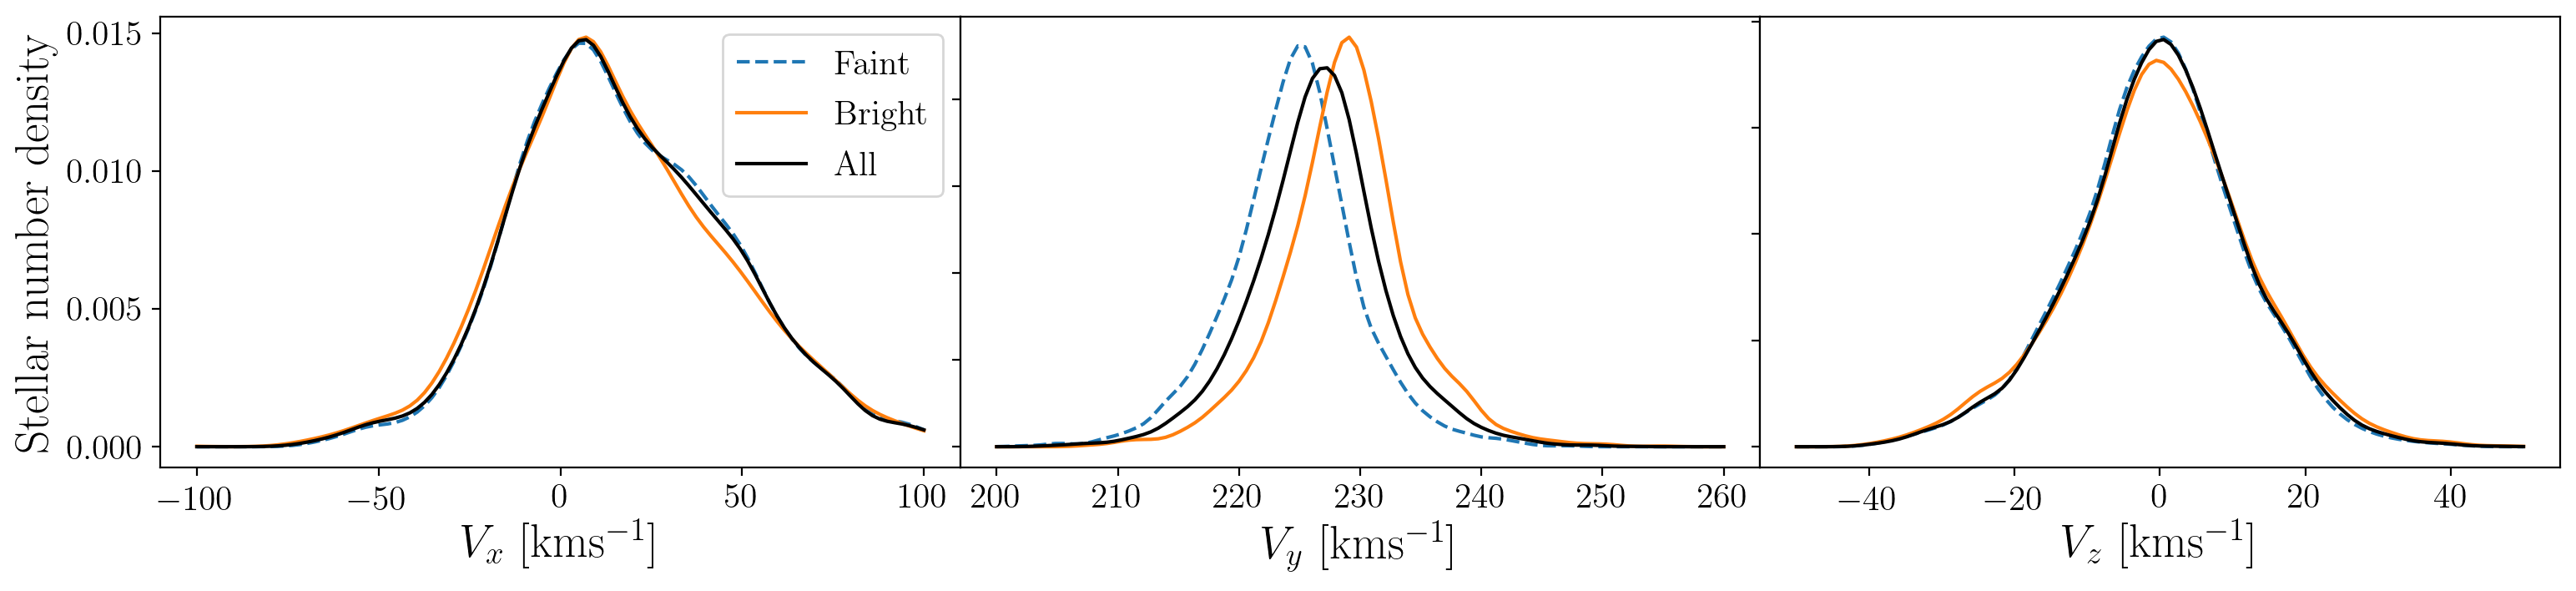

In [116]:
n = 20

fig = plt.figure(figsize=(16, 4), dpi=200)

ax0 = fig.add_subplot(131)
xs, k = kde(df_faint.vx_inferred.values, [-100, 100])
ax0.plot(xs, k, color="C0", ls="--", label="$\mathrm{Faint}$");
xs, k = kde(df_bright.vx_inferred.values, [-100, 100])
ax0.plot(xs, k, color="C1", label="$\mathrm{Bright}$");
xs, k = kde(df.vx_inferred.values, [-100, 100])
ax0.plot(xs, k, color="k", label="$\mathrm{All}$");
ax0.set_xlabel("$V_x~\mathrm{[kms^{-1}]}$")
ax0.set_ylabel("$\mathrm{Stellar~number~density}$")
ax0.legend();

ax1 = fig.add_subplot(132)
xs, k = kde(df_faint.vy_inferred.values, [200, 260])
ax1.plot(xs, k, color="C0", ls="--", label="$\mathrm{Faint~prior}$");
xs, k = kde(df_bright.vy_inferred.values, [200, 260])
ax1.plot(xs, k, color="C1", label="$\mathrm{Bright~prior}$");
xs, k = kde(df.vy_inferred.values, [200, 260])
ax1.plot(xs, k, color="k", label="$\mathrm{All~prior}$");
ax1.set_xlabel("$V_y~\mathrm{[kms^{-1}]}$")
ax1.set_yticklabels([])

ax2 = fig.add_subplot(133)
xs, k = kde(df_faint.vz_inferred.values, [-50, 50])
ax2.plot(xs, k, color="C0", ls="--", label="$\mathrm{Faint~prior}$");
xs, k = kde(df_bright.vz_inferred.values, [-50, 50])
ax2.plot(xs, k, color="C1", label="$\mathrm{Bright~prior}$");
xs, k = kde(df.vz_inferred.values, [-50, 50])
ax2.plot(xs, k, color="k", label="$\mathrm{All~prior}$");
ax2.set_xlabel("$V_z~\mathrm{[kms^{-1}]}$")
ax2.set_yticklabels([])

plt.tight_layout()
plt.subplots_adjust(wspace=0)
plt.savefig("prior_comparison")
plt.savefig("../../paper/prior_comparison.pdf")

In [117]:
print(np.abs(np.median(df_faint.vx_inferred.values) - np.median(df_bright.vx_inferred.values)))
print(np.abs(np.median(df_faint.vy_inferred.values) - np.median(df_bright.vy_inferred.values)))
print(np.abs(np.median(df_faint.vz_inferred.values) - np.median(df_bright.vz_inferred.values)))

2.2510797150863944
4.158583752570422
0.2700876075652837


In [95]:
print(np.std(df_faint.vx_inferred.values), np.std(df_bright.vx_inferred.values))
print(np.std(df_faint.vy_inferred.values), np.std(df_bright.vy_inferred.values))
print(np.std(df_faint.vz_inferred.values), np.std(df_bright.vz_inferred.values))

print("Delta sigma_vz = {:.2f}".format(abs(np.std(df_faint.vz_inferred.values) - np.std(df_bright.vz_inferred.values))))
print("Delta sigma_vz (bright) = {:.2f}".format(abs(np.std(df.vz_inferred.values) - np.std(df_bright.vz_inferred.values))))
print("Delta sigma_vz (faint) = {:.2f}".format(abs(np.std(df_faint.vz_inferred.values) - np.std(df.vz_inferred.values))))

29.348180356711914 30.073501668884084
5.294487105773166 5.427413621755391
11.4878548431458 12.27545557285985
Delta sigma_vz = 0.79
Delta sigma_vz (bright) = 0.34
Delta sigma_vz (faint) = 0.45


In [96]:
import astropy.stats as aps

print(1.5*aps.median_absolute_deviation(df_faint.vx_inferred.values), 1.5*aps.median_absolute_deviation(df_bright.vx_inferred.values))
print(1.5*aps.median_absolute_deviation(df_faint.vy_inferred.values), 1.5*aps.median_absolute_deviation(df_bright.vy_inferred.values))
print(1.5*aps.median_absolute_deviation(df_faint.vz_inferred.values), 1.5*aps.median_absolute_deviation(df_bright.vz_inferred.values))

print("Delta sigma_vz = {:.2f}".format(abs(1.5*aps.median_absolute_deviation(df_faint.vz_inferred.values)
                                       - 1.5*aps.median_absolute_deviation(df_bright.vz_inferred.values))))

print("Delta sigma_vz (bright) = {:.2f}".format(abs(1.5*aps.median_absolute_deviation(df.vz_inferred.values)
                                       - 1.5*aps.median_absolute_deviation(df_bright.vz_inferred.values))))

print("Delta sigma_vz (faint) = {:.2f}".format(abs(1.5*aps.median_absolute_deviation(df.vz_inferred.values)
                                       - 1.5*aps.median_absolute_deviation(df_faint.vz_inferred.values))))

29.48076328933801 28.944049654734723
4.450755108724863 4.294470711703028
10.458123610066485 11.137182145595366
Delta sigma_vz = 0.68
Delta sigma_vz (bright) = 0.48
Delta sigma_vz (faint) = 0.20
